In [31]:
import unicodedata
import re

In [32]:
def normalize_armenian(text: str) -> str:
    text = unicodedata.normalize('NFC', text)

    text = text.replace("եւ", "և")

    text = text.replace("«", "").replace("»", "")

    text = text.replace("—", "-").replace("–", "-")

    text = text.replace("“", "").replace("”", "").replace("'", "").replace('"', "")

    text = re.sub(r"[^Ա-Ֆա-և0-9\-\s\.\?\!։:,]", " ", text)

    text = re.sub(r"\s+", " ", text)

    return text.strip()

In [33]:
def remove_numbers_dates_times(text: str) -> str:

    text = re.sub(r"\b\d+(?:-ին|-ի|-ից|-ը|-ն)?\b", " ", text)

    text = re.sub(r"\b\d{1,4}[-\/\.]\d{1,2}[-\/\.]\d{1,4}\b", " ", text)
    text = re.sub(r"\b\d{1,2}[-\/\.]\d{1,2}\b", " ", text)

    text = re.sub(r"\b\d{1,2}[:։\.]\d{2}(?:-ին|-ի)?\b", " ", text)

    text = re.sub(r"թ\.", " ", text)

    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [34]:
def split_sentences_armenian(text):

    text = re.sub(r'[:։:]+', '|SENT|', text)

    sentences = text.split('|SENT|')

    sentences = [s.strip() for s in sentences if s.strip()]

    return sentences

In [35]:
def remove_single_capital_letters_with_dot(tokenized_sentences):
    new_sentences = []
    for sentence in tokenized_sentences:
        filtered = [w for w in sentence if not (len(w) == 1 and w.isupper())]
        if filtered:
            new_sentences.append(filtered)
    return new_sentences

In [36]:
def remove_punctuation(sentence: str) -> str:

    punctuations = r"[.,:;՝՛՞!?«»“”\"'—\-(){}\[\]…]"

    sentence = re.sub(punctuations, " ", sentence)

    sentence = re.sub(r"\s+", " ", sentence)

    return sentence.strip()

In [37]:
def tokenize_sentence(sentence: str):
    tokens = sentence.split()
    return tokens

In [38]:
from collections import Counter

def get_word_frequencies(tokenized_sentences):
    all_tokens = [token for sentence in tokenized_sentences for token in sentence]
    freq = Counter(all_tokens)
    return freq

In [39]:
def remove_rare_words(tokenized_sentences, min_freq=5):

    freq = get_word_frequencies(tokenized_sentences)

    filtered_sentences = []
    for sentence in tokenized_sentences:
        filtered = [word for word in sentence if freq[word] >= min_freq]
        if filtered:
            filtered_sentences.append(filtered)

    return filtered_sentences


In [40]:
def preprocess_armenian_text(texts, min_freq=5):
    all_tokenized_sentences = []

    for text in texts:
        text = normalize_armenian(text)
        text = remove_numbers_dates_times(text)
        sentences = split_sentences_armenian(text)

        cleaned_sentences = [remove_punctuation(s) for s in sentences]

        tokenized_sentences = [tokenize_sentence(s) for s in cleaned_sentences if s]

        tokenized_sentences = remove_single_capital_letters_with_dot(tokenized_sentences)

        all_tokenized_sentences.extend(tokenized_sentences)

    final_sentences = remove_rare_words(all_tokenized_sentences, min_freq=min_freq)

    return final_sentences


In [41]:
from pathlib import Path

def load_texts_simple(root_dir):
    root = Path(root_dir) / "train"
    return [path.read_text(encoding="utf-8")
            for path in root.rglob("*.txt")]


In [42]:
root_dir = r"C:\Users\MSI GF66\PycharmProjects\NLP\Word2Vec\ilur-news-corpus"

texts = load_texts_simple(root_dir)

clean_corpus = preprocess_armenian_text(texts, min_freq=5)

print(len(clean_corpus))
print(clean_corpus[:3])


82058
[['Փետրվարին', 'Վայոց', 'Ձորի', 'Ջերմուկ', 'քաղաքում', 'արձանագրված', 'սննդային', 'թունավորման', 'դեպքը', 'մարտի', 'ավարտվել', 'է', 'մահվան', 'ելքով', 'հայտնում', 'է', 'ՀՀ', 'Առողջապահության', 'նախարարությունը'], ['թունավորման', 'պատճառ', 'էր', 'հանդիսացել', 'փետրվարի', 'տնային', 'պայմաններում', 'պատրաստված', 'օգտագործումը'], ['Հաջորդ', 'օրը', 'հիվանդի', 'մոտ', 'ի', 'հայտ', 'են', 'եկել', 'բոտուլիզմին', 'բնորոշ', 'հետևյալ', 'ախտանշանները', 'թուլություն', 'գլխացավ', 'գլխապտույտ', 'ակտի', 'խանգարում']]


In [48]:
from gensim.models import Word2Vec

print(f"Total sentences: {len(clean_corpus)}")
print("Sample sentence:", clean_corpus[0])

model = Word2Vec(
    sentences=clean_corpus,
    vector_size=300,
    window=5,
    min_count=5,
    workers=8,
    sg=1,
    negative=15,
    epochs=20
)

model.save("armenian_word2vec.model")

print(f"Vocabulary size: {len(model.wv)}")


Total sentences: 82058
Sample sentence: ['Փետրվարին', 'Վայոց', 'Ձորի', 'Ջերմուկ', 'քաղաքում', 'արձանագրված', 'սննդային', 'թունավորման', 'դեպքը', 'մարտի', 'ավարտվել', 'է', 'մահվան', 'ելքով', 'հայտնում', 'է', 'ՀՀ', 'Առողջապահության', 'նախարարությունը']
Vocabulary size: 23453


In [60]:
model = Word2Vec.load("armenian_word2vec.model")

print("\nWords similar to 'Հայաստան':")
print(model.wv.most_similar("Հայաստան", topn=5))

print("\nWords similar to 'կառավարություն':")
print(model.wv.most_similar("կառավարություն", topn=5))

print("\n Երևան - Հայաստան + Ֆրանսիա =")
result = model.wv.most_similar(
    positive=['Երևան', 'Ֆրանսիա'],
    negative=['Հայաստան'],
    topn=5
)
print(result)

print("\nSimilarity between 'Հայաստան' and 'Վրաստան':",
      model.wv.similarity("Հայաստան", "Վրաստան"))



Words similar to 'Հայաստան':
[('Ադրբեջան', 0.50413578748703), ('Վրաստան', 0.46259674429893494), ('Իրան', 0.4604329764842987), ('Բարգավաճ', 0.45890143513679504), ('Լյուքսեմբուրգ', 0.43448975682258606)]

Words similar to 'կառավարություն':
[('անառարկելի', 0.47837328910827637), ('մեծամասնություն', 0.4716692566871643), ('Սևանը', 0.46701580286026), ('Նպատակն', 0.46258315443992615), ('արեցինք', 0.45861566066741943)]

 Երևան - Հայաստան + Ֆրանսիա =
[('Գասկե', 0.427783340215683), ('Ագուտ', 0.42166340351104736), ('Տրոիցկի', 0.41427722573280334), ('Նիժնի', 0.41290730237960815), ('Վիսկոնտիի', 0.41236960887908936)]

Similarity between 'Հայաստան' and 'Վրաստան': 0.46259677


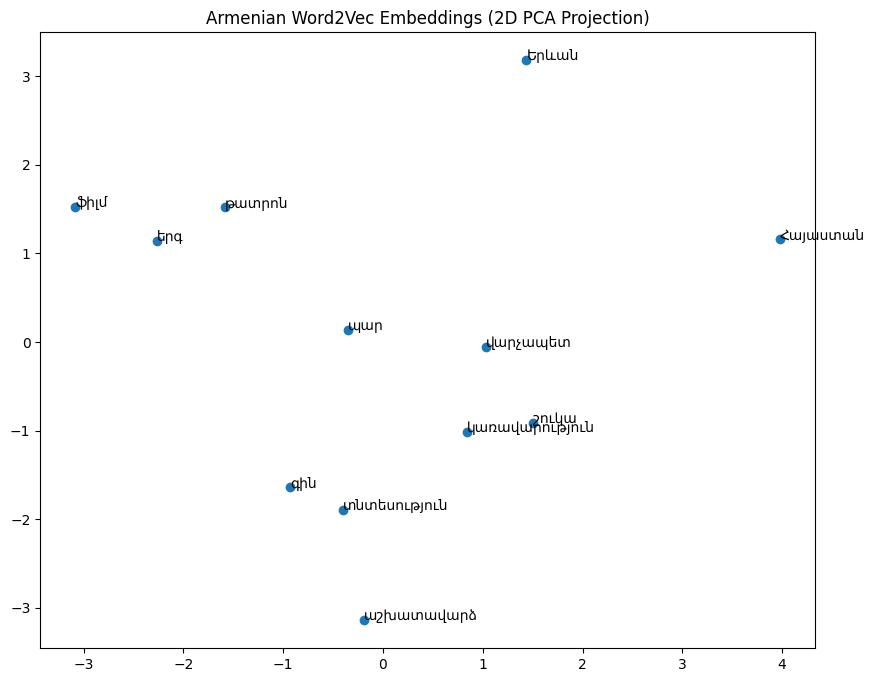

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = [
    'Հայաստան', 'Երևան', 'կառավարություն', 'վարչապետ',
    'տնտեսություն', 'շուկա', 'գին', 'աշխատավարձ',
    'երգ', 'պար', 'թատրոն', 'ֆիլմ'
]

valid_words = [w for w in words if w in model.wv]
vectors = [model.wv[w] for w in valid_words]

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(valid_words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.title("Armenian Word2Vec Embeddings (2D PCA Projection)")
plt.show()
